In [17]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calc_simple_sta(stimulus, spike_train, start = 0, end = 1):
    """
    Calculates the spike-triggered average (STA) of a 2D stimulus of shape [time, x, y]
    
    Args:
        stimulus (np.ndarray): 3D array of shape [time, height, width], where each 2D frame is the stimulus at a given time.
        spike_train (np.ndarray): 1D array of shape with the same length as stimulus in time, consisting of 0s and 1s (0: no spike, 1: spike)
        start (int): Start offset relative to each spike time. (inclusive!)
        end (int): End offset relative to each spike time. (exclusive!)

    Returns:
        sta (np.ndarray): 3D array of shape [lag, height, width]. Height and width contain the average stimulus that caused a spike with respect to the given window (start/end) and in terms of lags.
    
    Note:
        By default start and end are set to take only the stimulus that was present during each spike.
    """
    # Sanity Checks
    if stimulus.ndim != 3:
        raise ValueError("Stimulus must be a 3D array: [time, height, width].")
    if len(spike_train) != stimulus.shape[0]:
        raise ValueError("spike_train length must match the first (time) dimension of stimulus.")
    if end < start:
        raise ValueError("End must be after start.")

    spikes, = np.where(spike_train == 1)
    if spikes.size == 0:
        raise ValueError('Found no spikes in the given spike train.')
    
    n_lags = end - start
    sta = np.zeros((n_lags, stimulus.shape[1], stimulus.shape[2]))
    spike_count = 0

    for spike in spikes:
        window_start = spike + start
        window_end = spike + end
        if window_start < 0 or window_end > len(stimulus):
            print(f'Exceeding: {window_start} - {window_end}')
            continue

        for i_lag, time_point in enumerate(range(window_start, window_end)):
            sta[i_lag] += stimulus[time_point]
            
        spike_count += 1

    sta /= spike_count
    # sta -= sta.mean()  # Skipping this has actually given less noisy results
    
    for i_lag in range(n_lags): # And I think I have to do this
        sta[i_lag] -= sta[i_lag].mean()

    return sta

def plot_simple_sta(sta, filter, start, end):
    n_lags = end - start
    
    fig, axs = plt.subplots(1, n_lags + 1, figsize=(3*(n_lags + 1), 4))
    for i_lag in range(n_lags): 
        im = axs[i_lag].imshow(sta[i_lag], vmin=-2, vmax=2, cmap="seismic") 
        axs[i_lag].set_title(f"lag {i_lag + start}") 

    filt_im = axs[-1].imshow(filter, vmin=-2, vmax=2, cmap="seismic") 
    axs[-1].set_title("Filter") 

    fig.colorbar(filt_im, ax=axs.ravel().tolist(), label="Intensity")

In [19]:
data_dir = ''
gauss_spike_train = np.load(os.path.join(data_dir, 'spike_train_gauss_1.npy'))
gauss_stimulus = np.load(os.path.join(data_dir, 'stimulus_gauss_1.npy'))
gauss_filter = np.load(os.path.join(data_dir, f'filter_gauss_1.npy'))

gabor_spike_train = np.load(os.path.join(data_dir, 'spike_train_gabor_1.npy'))
gabor_stimulus = np.load(os.path.join(data_dir, 'stimulus_gabor_1.npy'))
gabor_filter = np.load(os.path.join(data_dir, f'filter_gabor_1.npy'))

ricker_spike_train = np.load(os.path.join(data_dir, 'spike_train_ricker_1.npy'))
ricker_stimulus = np.load(os.path.join(data_dir, 'stimulus_ricker_1.npy'))
ricker_filter = np.load(os.path.join(data_dir, f'filter_ricker_1.npy'))


In [20]:
start = -4
end = 5
n_lags = end - start

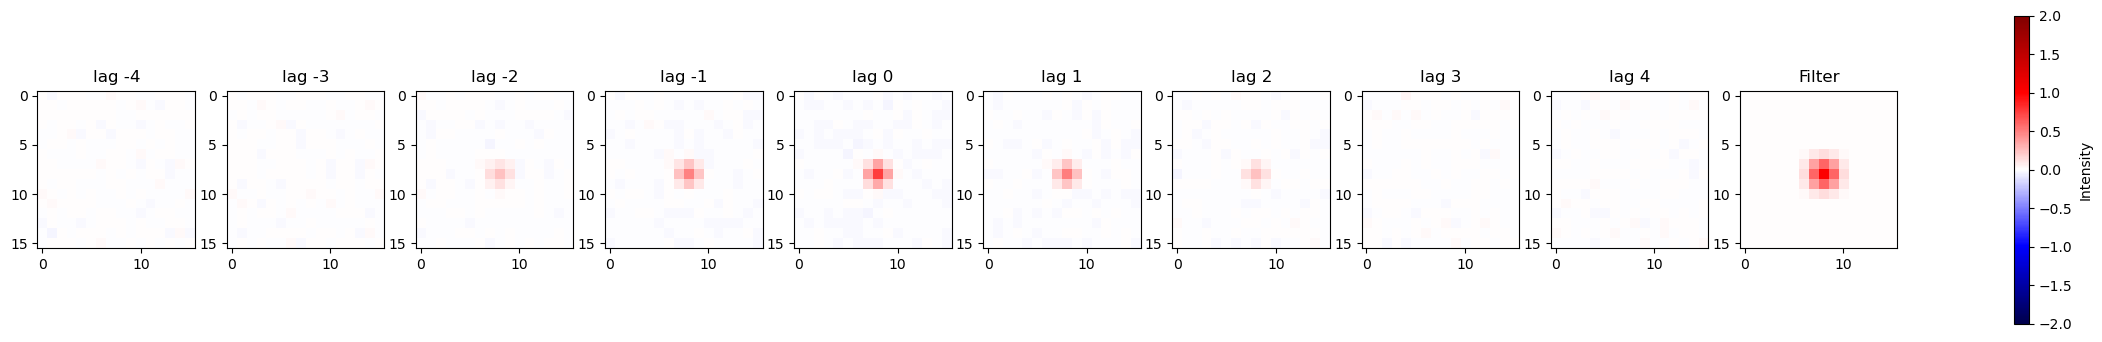

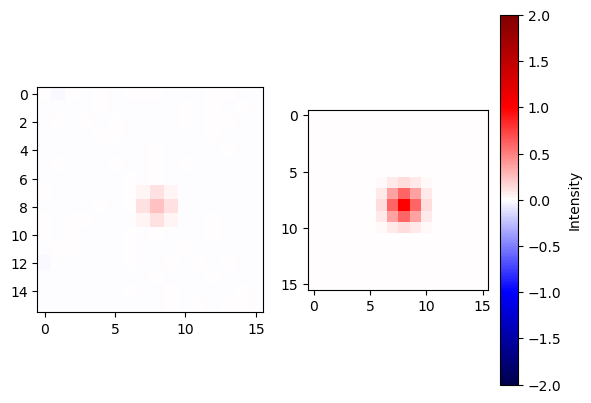

In [21]:
gauss_sta = calc_simple_sta(gauss_stimulus, gauss_spike_train, start, end)
plot_simple_sta(gauss_sta, gauss_filter, start, end)

gauss_sta = gauss_sta.mean(axis = 0)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(gauss_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(gauss_filter, vmin = -2, vmax = 2, cmap = "seismic")
plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

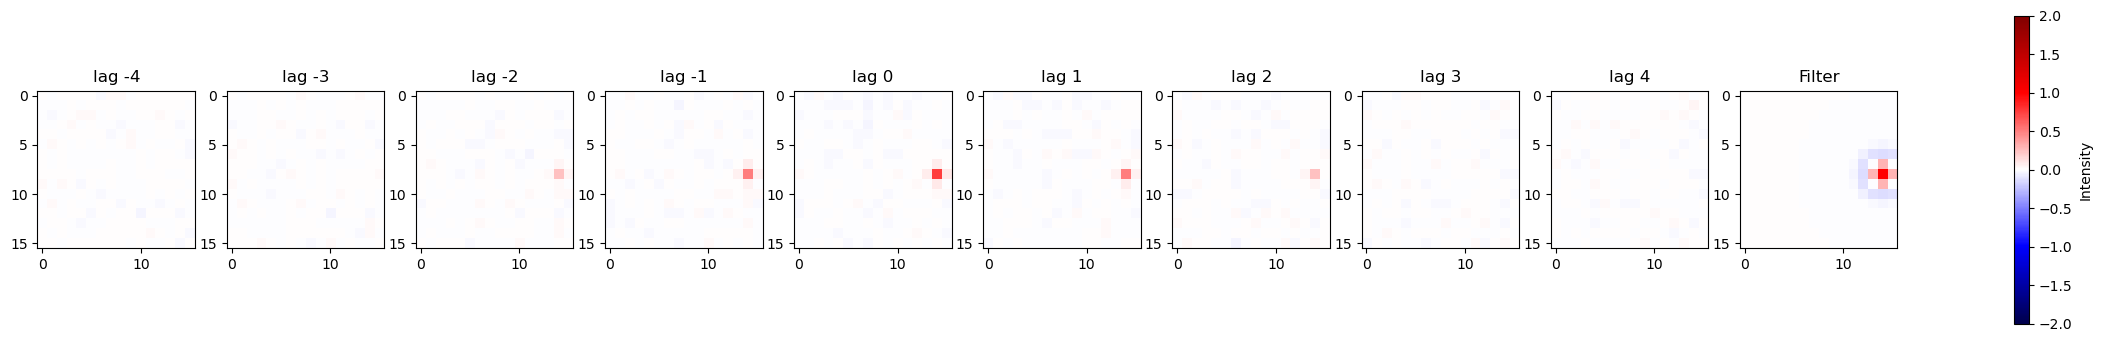

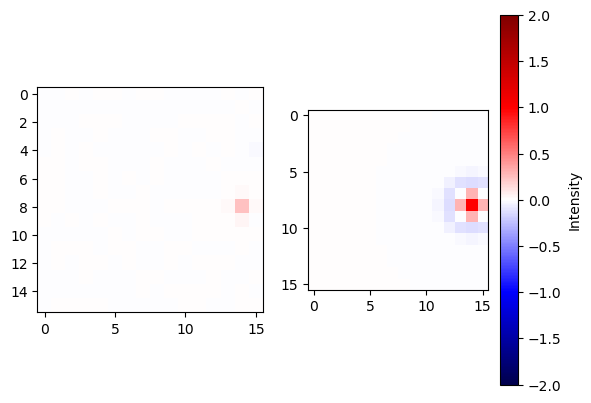

In [22]:
ricker_sta = calc_simple_sta(ricker_stimulus, ricker_spike_train, start, end)
plot_simple_sta(ricker_sta, ricker_filter, start, end)

ricker_sta = ricker_sta.mean(axis = 0)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(ricker_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(ricker_filter, vmin = -2, vmax = 2, cmap = "seismic")

plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

Exceeding: -1 - 8
Exceeding: 999995 - 1000004
Exceeding: 999996 - 1000005
Exceeding: 999997 - 1000006


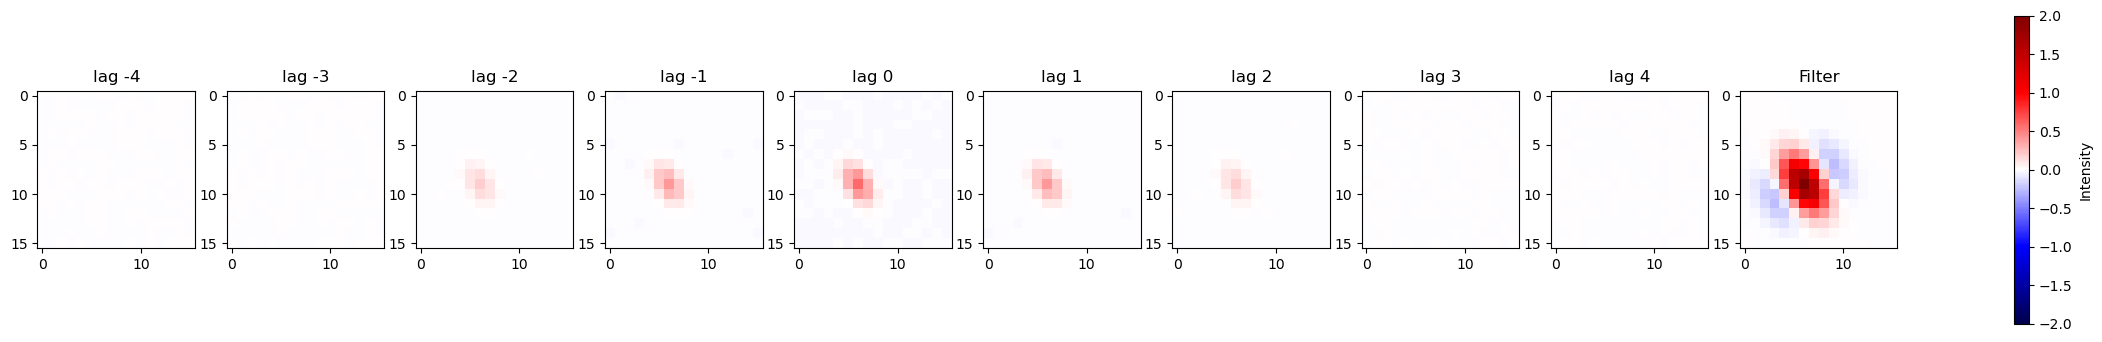

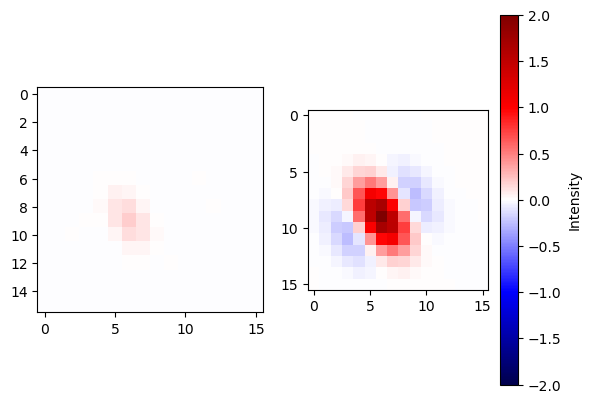

In [23]:
gabor_sta = calc_simple_sta(gabor_stimulus, gabor_spike_train, start, end)
plot_simple_sta(gabor_sta, gabor_filter, start, end)

gabor_sta = gabor_sta.mean(axis = 0)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(gabor_sta, vmin = -2, vmax = 2, cmap = "seismic")
a = axs[1].imshow(gabor_filter, vmin = -2, vmax = 2, cmap = "seismic")

plt.colorbar(a, label="Intensity")
plt.title(f'')
plt.show()

In [24]:
mse = np.mean((gauss_sta - gauss_filter)**2)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 0.0082
